In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_10_mixup_ls")' FastaiNotebook_10_mixup_ls

Installing packages:
	.package(path: "/home/ubuntu/fastai_docs/dev_swift/FastaiNotebook_10_mixup_ls")
		FastaiNotebook_10_mixup_ls
With SwiftPM flags: []
Working in: /tmp/tmp9ctavr36/swift-install
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Initializing Swift...
Installation complete!


In [ ]:
// export
import Path
import TensorFlow

In [ ]:
import FastaiNotebook_10_mixup_ls

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


## Load data

Will train on imagenette when it's possible without OOM.

In [ ]:
let path = downloadImagette()

In [ ]:
let il = ItemList(fromFolder: path, extensions: ["jpeg", "jpg"])
let sd = SplitData(il, fromFunc: {grandParentSplitter(fName: $0, valid: "val")})
var (procItem,procLabel) = (NoopProcessor<Path>(),CategoryProcessor())
let sld = SplitLabeledData(sd, fromFunc: parentLabeler, procItem: &procItem, procLabel: &procLabel)
var rawData = sld.toDataBunch(itemToTensor: pathsToTensor, labelToTensor: intsToTensor)
let data = transformData(rawData, tfmItem: { openAndResize(fname: $0, size: 128) })

In [ ]:
let batch = data.train.oneBatch()!

In [ ]:
batch.xb.shape

▿ TensorShape
  ▿ dimensions : 4 elements
    - 0 : 64
    - 1 : 128
    - 2 : 128
    - 3 : 3


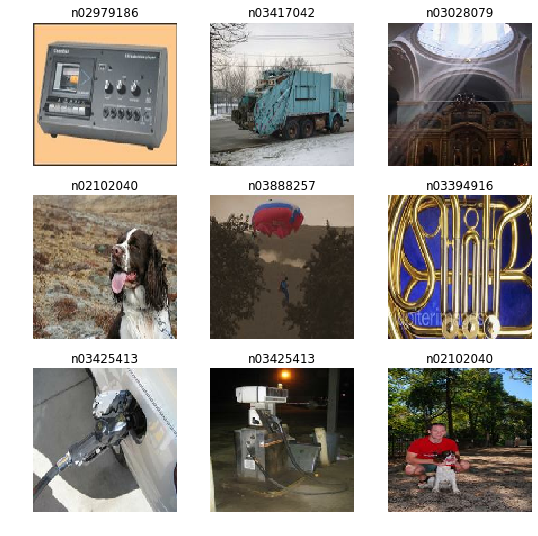

In [ ]:
let labels = batch.yb.scalars.map { sld.train.procLabel.vocab![Int($0)] }
showImages(batch.xb, labels: labels)

## XResnet

In [ ]:
public struct ConvLayer: Layer {
    public var bn: FABatchNorm<Float>
    public var conv: FANoBiasConv2D<Float>
    
    public init(_ cIn: Int, _ cOut: Int, ks: Int = 3, stride: Int = 1, zeroBn: Bool = false, act: Bool = true){
        bn = FABatchNorm(featureCount: cOut)
        conv = FANoBiasConv2D(filterShape: (ks, ks, cIn, cOut), 
                              strides: (stride,stride), 
                              padding: .same, 
                              activation: act ? relu : identity)
        if zeroBn { bn.scale = Tensor(zeros: [cOut]) }
    }
    
    @differentiable
    public func call(_ input: TF) -> TF {
        return bn(conv(input))
    }
}

In [ ]:
//A layer that you can switch off to do the identity instead
public protocol SwitchableLayer: Layer {
    associatedtype Input
    var isOn: Bool {get set}
    
    @differentiable func forward(_ input: Input) -> Input
}

public extension SwitchableLayer {
    func call(_ input: Input) -> Input {
        return isOn ? forward(input) : input
    }

    @differentiating(call)
    func gradForward(_ input: Input) ->
        (value: Input, pullback: (Self.Input.CotangentVector) ->
            (Self.CotangentVector, Self.Input.CotangentVector)) {
        if isOn { return valueWithPullback(at: input) { $0.forward($1) } }
        else { return (input, {v in return (Self.CotangentVector.zero, v)}) }
    }
}

In [ ]:
public struct MaybeAvgPool2D: SwitchableLayer {
    var pool: AvgPool2D<Float>
    @noDerivative public var isOn = false
    
    @differentiable public func forward(_ input: TF) -> TF { return pool(input) }
    
    public init(_ sz: Int) {
        isOn = (sz > 1)
        pool = AvgPool2D<Float>(poolSize: (sz, sz), strides: (sz, sz))
    }
}

In [ ]:
public struct MaybeConv: SwitchableLayer {
    var conv: ConvLayer
    @noDerivative public var isOn = false
    
    @differentiable public func forward(_ input: TF) -> TF { return conv(input) }
    
    public init(_ cIn: Int, _ cOut: Int) {
        isOn = (cIn > 1) || (cOut > 1)
        conv = ConvLayer(cIn, cOut, ks: 1, act: false)
    }
}

In [ ]:
public struct ResBlock: Layer {
    public var convs: [ConvLayer]
    public var idConv: MaybeConv
    public var pool: MaybeAvgPool2D
    
    public init(_ expansion: Int, _ ni: Int, _ nh: Int, stride: Int = 1){
        let (nf, nin) = (ni*expansion,nh*expansion)
        convs = [ConvLayer(nin, nh, ks: 1)]
        convs += (expansion==1) ? [
            ConvLayer(nh, nf, ks: 3, stride: stride, zeroBn: true, act: false)
        ] : [
            ConvLayer(nh, nh, ks: 3, stride: stride),
            ConvLayer(nh, nf, ks: 1, zeroBn: true, act: false)
        ]
        idConv = nin==nf ? MaybeConv(1,1) : MaybeConv(nin, nf)
        pool = MaybeAvgPool2D(stride)
    }
    
    @differentiable
    public func call(_ inp: TF) -> TF {
        return relu(convs(inp) + idConv(pool(inp)))
    }
    
}

In [ ]:
public struct XResNet {
    public var stem: [ConvLayer]
    public var maxPool = MaxPool2D<Float>(poolSize: (3,3), strides: (2,2), padding: .same)
    public var blocks: [ResBlock]
    public var pool = GlobalAvgPool2D<Float>()
    public var linear: Dense<Float>
    
    public init(_ expansion: Int, _ layers: [Int], cIn: Int = 3, cOut: Int = 1000){
        let nfs = [cIn, (cIn+1)*8, 64, 64]
        stem = Array(0..<3).map{ ConvLayer(nfs[$0], nfs[$0+1], stride: $0==0 ? 2 : 1)}
        let nfs1 = [64/expansion,64,128,256,512]
        blocks = Array(layers.enumerated).map { (i,l) in 
            return makeLayer(expansion, nfs[i], nfs[i+1], l, stride: i==0 ? 1 : 2)
        }.reduce([], +)
        linear = Dense(inputSize: nfs.last!*expansion, outputSize: cOut)
    }
    
    private func makeLayer(_ expansion: Int, _ ni: Int, _ nf: Int, _ nBlocks: Int, stride: Int) -> [ResBlock] {
        return Array(0..<nBlocks).map { ResBlock(expansion, $0==0 ? ni : nf, nf, stride: $0==0 ? 1 : stride) }
    }
    
    @differentiable
    public func call(_ inp: TF) -> TF {
        return linear(pool(blocks(maxPool(stem(inp)))))
    }
    
}

: 

In [ ]:
public struct XResNet {
    public var stem: [ConvLayer]
    public var maxPool = MaxPool2D<Float>(poolSize: (3,3), strides: (2,2), padding: .same)
    public var blocks: [ResBlock]
    public var pool = GlobalAvgPool2D<Float>()
    public var linear: Dense<Float>
    
    public init(_ expansion: Int, _ layers: [Int], cIn: Int = 3, cOut: Int = 1000){
        let nfs = [cIn, (cIn+1)*8, 64, 64]
        stem = Array(0..<3).map{ ConvLayer(nfs[$0], nfs[$0+1], stride: $0==0 ? 2 : 1)}
        let nfs1 = [64/expansion,64,128,256,512]
        blocks = Array(layers.enumerated).map { (i,l) in 
            return Array(0..<l).map { ResBlock(expansion, $0==0 ? nfs[i] : nfs[i+1], nfs[i+1], 
                                                     stride: $0==0 ? 1 : (i==0 ? 1 : 2)) }
        }.reduce([], +)
        linear = Dense(inputSize: nfs.last!*expansion, outputSize: cOut)
    }
    
    @differentiable
    public func call(_ inp: TF) -> TF {
        return linear(pool(blocks(maxPool(stem(inp)))))
    }
    
}

: 